# Aprendizado de Máquina - Predição de Preços na Bolsa de Valores (PETR4.SA)

## Instalação dos pacotes necessários

In [1]:

import warnings
warnings.filterwarnings('ignore')

!pip install numpy
!pip install matplotlib
!pip install yfinance
!pip install scikit-learn
!pip install pandas
!pip install pandas-ta

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Importando os pacotes necessários

In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Baixando dados da Ação PETR4.SA Utilizando o Yahoo Finance

In [3]:
petr4 = yf.Ticker("PETR4.SA") # instanciando o yfinance com o Ticket de nossa ação
df = petr4.history(period="10y") # dizendo que queremos os dados históricos de 10 anos
df.drop(["Volume", "Dividends", "Stock Splits"], axis=1, inplace=True)
print(df.head(10)) # inprimindo os 10 primeiros elementos (df é um pd.DataFrame, já sai bonitinho)

                               Open      High       Low     Close
Date                                                             
2014-09-15 00:00:00-03:00  6.499963  6.631567  6.438976  6.605888
2014-09-16 00:00:00-03:00  6.663665  7.183662  6.644406  6.917243
2014-09-17 00:00:00-03:00  7.167613  7.231811  7.016750  7.100206
2014-09-18 00:00:00-03:00  7.013541  7.100208  6.798481  6.833789
2014-09-19 00:00:00-03:00  6.740702  6.862676  6.641196  6.711813
2014-09-22 00:00:00-03:00  6.564160  6.612307  6.317000  6.609097
2014-09-23 00:00:00-03:00  6.451818  6.740705  6.387620  6.461447
2014-09-24 00:00:00-03:00  6.403668  6.615519  6.368359  6.493544
2014-09-25 00:00:00-03:00  6.512803  6.548111  6.365149  6.368359
2014-09-26 00:00:00-03:00  6.387618  6.817739  6.355519  6.721443


# Calculando o índice OHLC4 (Preço médio) usando a Pandas-TA

<AxesSubplot:xlabel='Date'>

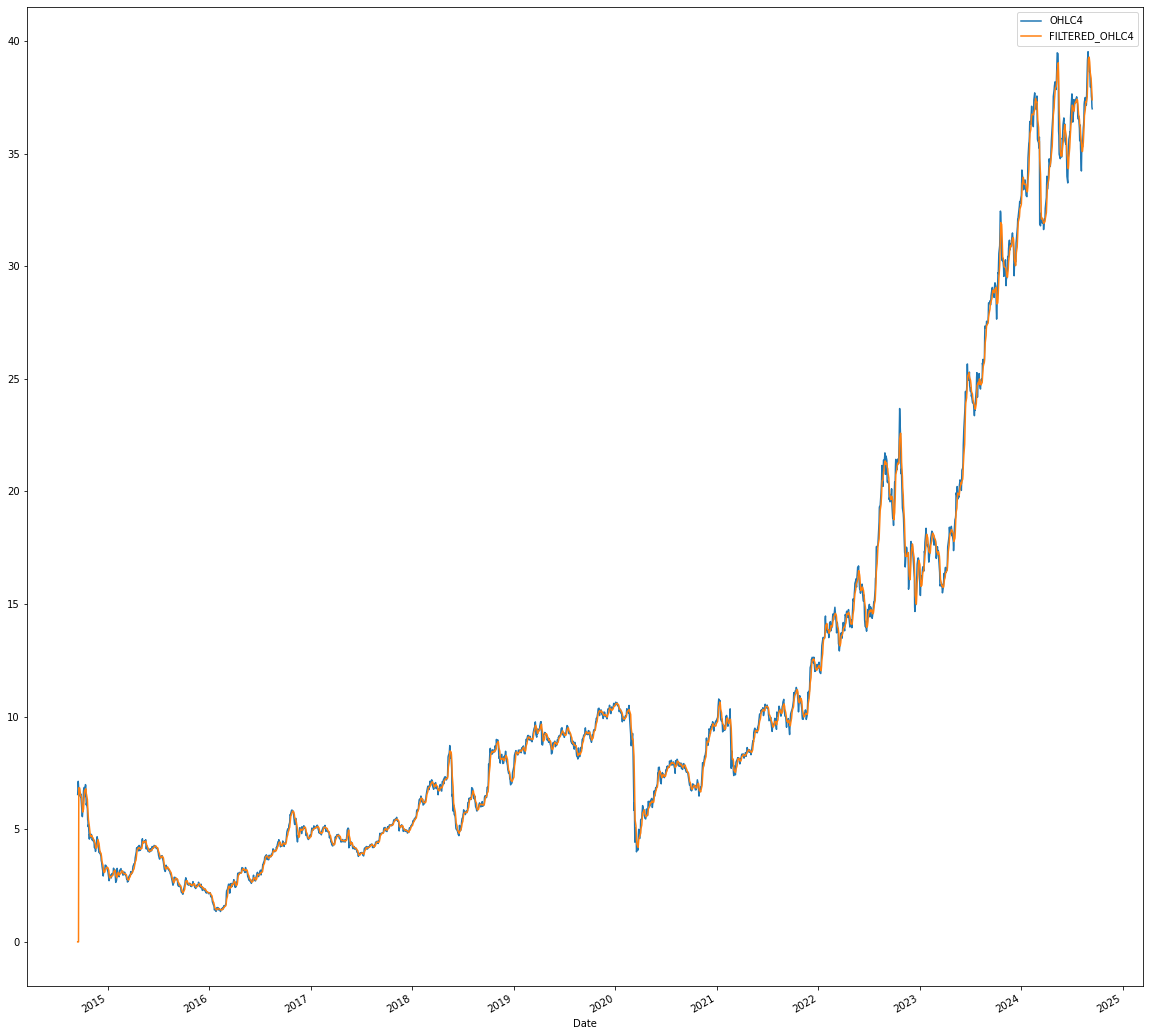

In [4]:
observed_ratio = 0.7
window_length = 5
filter_length = 5
f_string = "SMA_{:d}".format(filter_length)
ts = df.ta.ohlc4() # ts é uma pd.Series
smoothed_ohlc4 = ta.sma(close=ts, length=filter_length)
smoothed_ohlc4.fillna(0.0, inplace=True)
ts = pd.concat([ts, smoothed_ohlc4], axis=1)
ts = pd.DataFrame(ts)
ts.rename(columns={f_string: 'FILTERED_OHLC4'}, inplace=True)
ts.plot(figsize=(20, 20))

## Preparação de Dados

In [5]:
# cria o vetor de características atrasadas
def create_lagged_features(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])  # Features: n_lags valores anteriores
        y.append(data[i])           # Target: valor atual
    return np.array(X), np.array(y)

n_lags = 10
series = ts["FILTERED_OHLC4"].to_numpy()  # versão filtrada de OHLC4
diff_series = np.diff(series, prepend=series[0]) # tirando a tendência do OHLC4
X, y = create_lagged_features(diff_series, n_lags) # criando os vetores de treinamento
# acho melhor separar alguns dados para serem os não vistos - 30% da série vou utilizar para testes reais
X_t, y_t = X[0:int(observed_ratio*len(X))], y[0:int(observed_ratio*len(X))]
X_r, y_r = X[int(observed_ratio*len(X)):len(X)], y[int(observed_ratio*len(X)):len(y)]
# SGD é sensível à escala
scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)
X_r_scaled = scaler.transform(X_r)
# separação em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_t_scaled, y_t, test_size=0.2, shuffle=False)


## Instanciando e Treinando o Modelo SGD

In [6]:
sgd_regressor = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)

# Treinando o modelo
sgd_regressor.fit(X_train, y_train)

SGDRegressor(random_state=0)

## Testando o modelo com os dados de teste

In [7]:
# Fazendo previsões
y_pred = sgd_regressor.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Erro médio Quadrático (MSE): {mse:.4f}")

Erro médio Quadrático (MSE): 0.0026


O MSE deu um valor relativamente baixo, indicativo de bom treinamento

## Teste Com Dados Não Observados

In [8]:
# Fazendo previsões
y_r_pred = sgd_regressor.predict(X_r_scaled)

# Avaliando o modelo
mse = mean_squared_error(y_r, y_r_pred)
print(f"Erro médio Quadrático (MSE): {mse:.4f}")

Erro médio Quadrático (MSE): 0.0113


O MSE nos dados snão observados é cerca de 4.38 vezes o valor do MSE sobre os dados de teste.
Embora seja um tanto elevado em relação aos dados de teste, é apenas um estudo e não uma aplicação final.

## Plotando as Curvas do OHLC4 Original, Filtrado e Predito

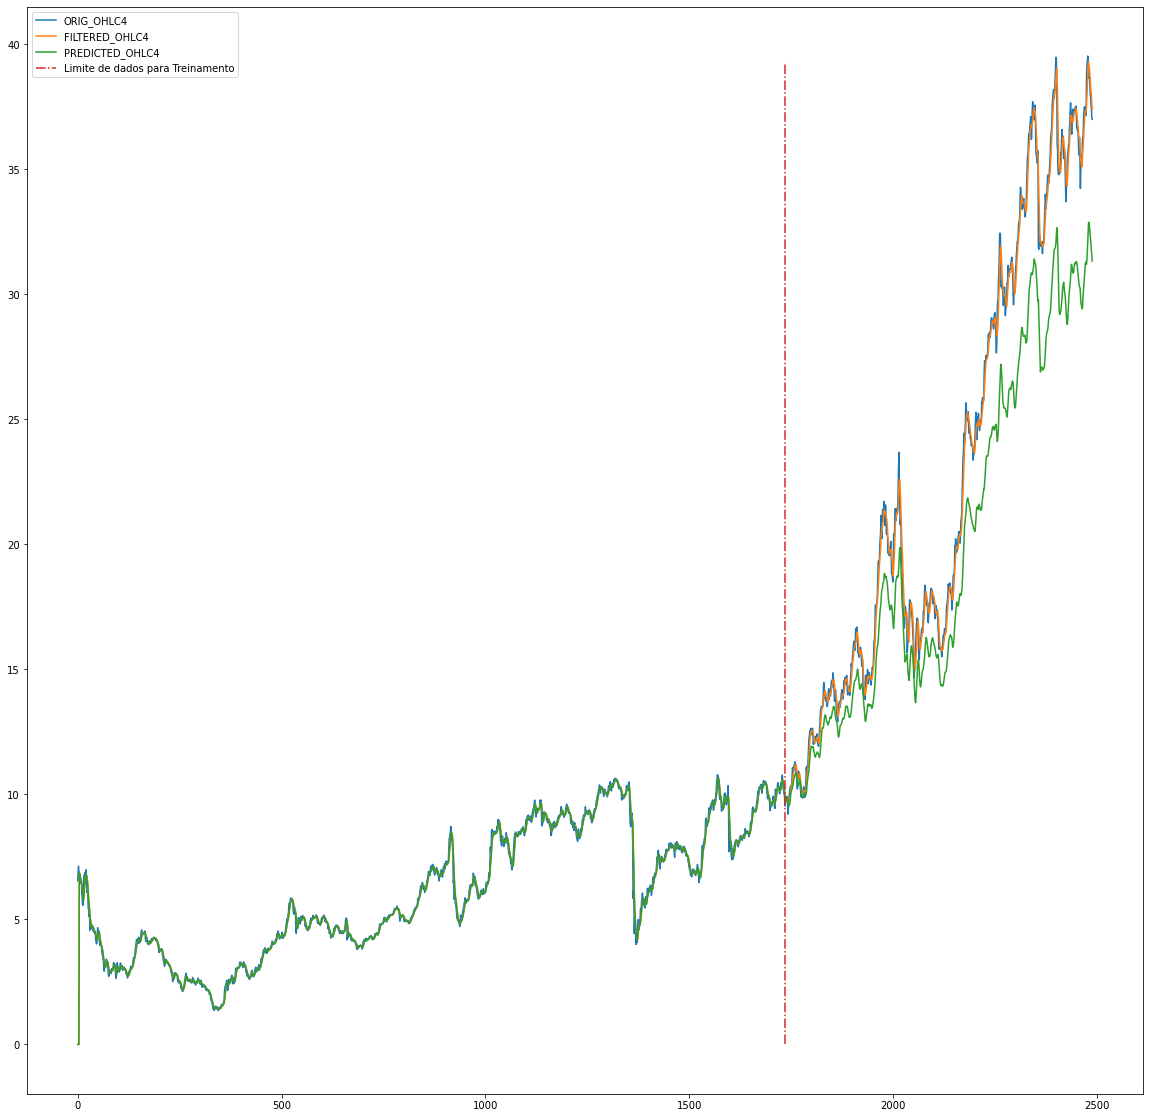

In [9]:
# somando pois a série de treinamento é a diferença sobre a curva original - nos dados nunca vistos é uma soma cumulativa
Y_r_pred = pd.Series(np.concatenate((series[0:len(series) - len(X_r_scaled)], series[len(series) - len(X_r) - 1] + np.cumsum(y_r_pred))), name="PREDICTED_OHLC4")
Orig_y = pd.Series(ts["OHLC4"].to_numpy(), name="ORIG_OHLC4")
Filtered_y = pd.Series(ts["FILTERED_OHLC4"].to_numpy(), name="FILTERED_OHLC4")
pts = pd.concat([Orig_y, Filtered_y, Y_r_pred], axis=1)
pts = pd.DataFrame(pts) # dataframe pronto
# linha limítrofe entre dados de treinamento e teste e os dados não observados
train_limit = int(observed_ratio*len(X))
min_y = np.min(series)
max_y = np.max(series)
limit_line_y = np.linspace(min_y, max_y, 100)
limit_line_x = np.ones(100) * int(observed_ratio*len(X))
# fazendo os gráficos
pts.plot(figsize=(20, 20))
plt.plot(limit_line_x, limit_line_y, linestyle='-.', label="Limite de dados para Treinamento")
plt.legend()
plt.show()

É possível ver que o modelo diverge bastante para os dados fora do treinamento e teste. 
O modelo tem performance de regular a péssima com a base de dados de treinamento feita.
Talvez seja melhor classificar a série ao invés de tentar regressão.